# specific hichub pileup on hic data


In [1]:
import pandas as pd
import hicstraw
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.pyplot as plt 
import seaborn as sns
import math
from matplotlib import rcParams
import os
import re
import numpy as np

## read hub

In [3]:
! ls ./hic_results/hichub_c10q0001/Ctrl_VS_4h

cluster_HL60_4h.txt    HL60_4h_specific_hubs.bed
cluster_HL60_Ctrl.txt  HL60_Ctrl_specific_hubs.bed


In [4]:
hub_path = './hic_results/hichub_c10q0001/Ctrl_VS_4h/'

Conditions = [f.split('_specific_hubs.bed')[0]  for f in os.listdir(hub_path) if re.match(r'.*specific_hubs.bed', f)]
Conditions

['HL60_Ctrl', 'HL60_4h']

In [5]:
## read hub
hub = []

for p in Conditions:
    hub.append(pd.read_csv(hub_path + p +"_specific_hubs.bed" , sep='\t'))
    

## anchor: left, middle ,right
### triangle diff hubs

In [6]:
## extract the triangle part and calculate the anchor(left, middle ,right )
for i in range(len(hub)):
    hub[i].columns = ['reg1','reg2','-log10(pvalue)','-log10(FDR)']
    reg1 = pd.concat([hub[i]['reg1'].str.split(':',expand=True)[0],
                      hub[i]['reg1'].str.split(':',expand=True)[1].str.split('-',expand=True)],axis=1)
    reg2 = pd.concat([hub[i]['reg2'].str.split(':',expand=True)[0],
                      hub[i]['reg2'].str.split(':',expand=True)[1].str.split('-',expand=True)],axis=1)
    hub[i] = pd.concat([reg1,reg2,hub[i]['-log10(FDR)']],axis=1)
    hub[i].columns = ['chr1','start1','end1','chr2','start2','end2','-log10(FDR)']

anchor = []
for i in range(len(hub)):
    hub_pyr = hub[i][hub[i]['start1']==hub[i]['start2']]
    anchor.append(hub_pyr[['chr1','start1']])
    anchor.append(pd.concat([hub_pyr['chr1'],((hub_pyr['start1'].astype(int) + 
                                               hub_pyr['end1'].astype(int))/2).astype(int)],axis=1))
    anchor.append(hub_pyr[['chr1','end1']])
for i in range(len(anchor)):
    anchor[i].columns = [0,1]

In [7]:
## all the # of diff hud
! wc -l ./hic_results/hichub_c10q0001/Ctrl_VS_4h/*bed

  1908 /home/qchen/PhD/Neu/OCEANC/Neu_H/hic_results/hichub_c10q0001/Ctrl_VS_4h/HL60_4h_specific_hubs.bed
   700 /home/qchen/PhD/Neu/OCEANC/Neu_H/hic_results/hichub_c10q0001/Ctrl_VS_4h/HL60_Ctrl_specific_hubs.bed
  2608 total


In [8]:
## number of triangle diff hub
[anchor[A].shape for A in range(len(anchor))]

[(666, 2), (666, 2), (666, 2), (1626, 2), (1626, 2), (1626, 2)]

## produce heatmap

In [10]:
path = '/home/qchen/PhD/Neu/OCEANC/Neu_H/hic_results/H_hicpro2juicebox/'

In [12]:
heatmap0 = []

# sample = ['BXPC_GSE185069','PANC1_GSE185069']
# path = '/home/szhu/hichub_cancer/pan_cancer/merge/'

sample = ['HL60_Ctrl','HL60_4h',"HL60_2d","HL60_4d"]
path = '/home/qchen/PhD/Neu/OCEANC/Neu_H/hic_results/H_hicpro2juicebox/'
for s in sample:
    
    hic0 = path + s +'.allValidPairs.hic'

    norm = 'NONE'
    # norm = "KR"
    resolution = 10**4
    window = 50*resolution
    
    # human
    chrom = list(range(1,23))+['X']

    for i in range(len(anchor)):
        matrix_all = []
        
        peak = anchor[i]

        hic = hicstraw.HiCFile(hic0)
        for j in chrom:

            peak0 = peak[peak[0]=='chr'+str(j)]
            peak0.index = list(range(0,len(peak0)))

            bin0 = np.floor(peak0[1].astype(int)/resolution).astype(int)*resolution
            mzd = hic.getMatrixZoomData(str(j), str(j), "oe",norm, "BP", resolution)

            for k in range(len(bin0)):
                gr1 = bin0[k]-window
                gr2 = bin0[k]+window
                gc1 = bin0[k]-window
                gc2 = bin0[k]+window
                matrix = mzd.getRecordsAsMatrix(gr1, gr2, gc1, gc2)
                if (len(matrix)==101): # and sum(matrix[50][51:100])>0
                    matrix_all.append(matrix)
        heatmap = sum(matrix_all)/len(matrix_all)
        heatmap0.append(heatmap)
        print(i)

0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5


# plot heatmap

In [13]:
len(anchor)

6

# Ctrl hub in ctrl data

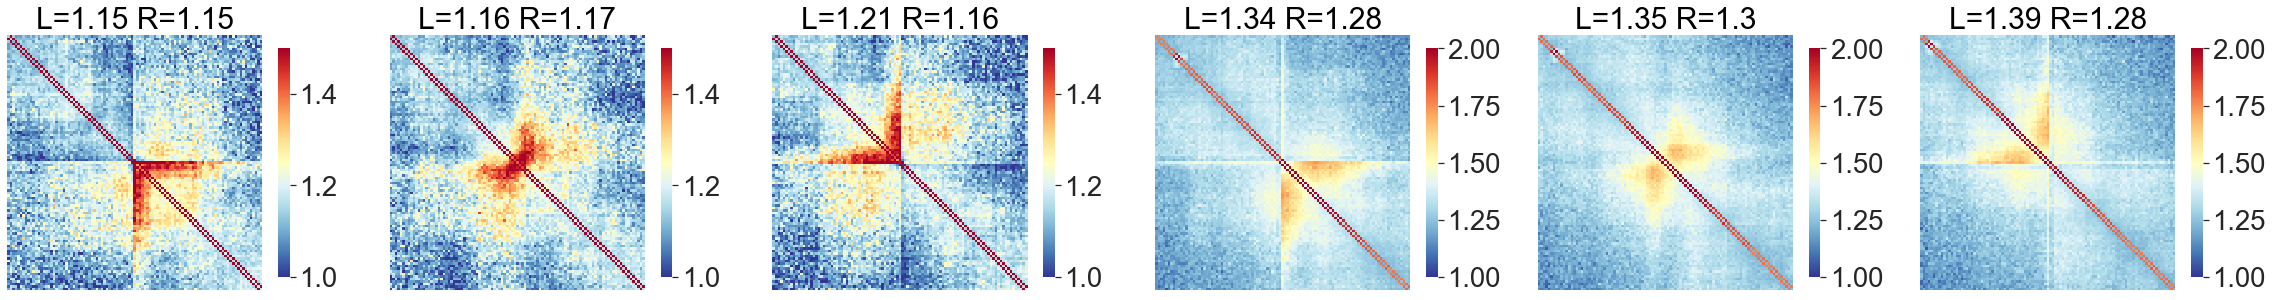

In [14]:
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 40,7
fig, axs = plt.subplots(1,len(anchor), sharey=True)
vmin = [1,1]; vmax = [1.5,2]
for i in range(len(anchor)):
    heatmap=heatmap0[i]
    if i < 3: m1 = vmin[0]; m2 = vmax[0]
    if i >= 3: m1 = vmin[1]; m2 = vmax[1]
    mean1 = np.round(np.mean(heatmap[0:50,0:50]),2)
    mean2 = np.round(np.mean(heatmap[0:50,51:100]),2)
    sns.set(font_scale=2.5)
    ax = sns.heatmap(heatmap, cmap="RdYlBu_r", square=True, 
                     vmin=m1, vmax=m2,
                     xticklabels=False, yticklabels=False,cbar_kws={"shrink": .6},ax=axs[i])
    ax.set_title('L='+str(mean1) + ' ' + 'R='+str(mean2), fontsize =30)

# 4h hub in 4h data

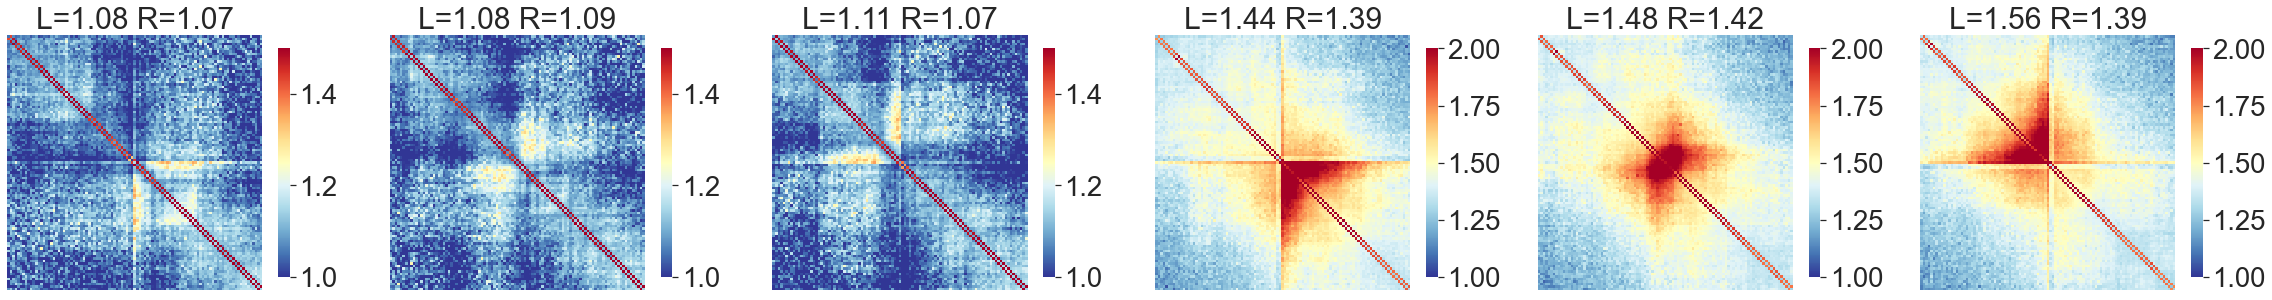

In [15]:
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 40,7
fig, axs = plt.subplots(1,len(anchor), sharey=True)
vmin = [1,1]; vmax = [1.5,2]
for i in range(len(anchor)):
    heatmap=heatmap0[i+6]
    if i < 3: m1 = vmin[0]; m2 = vmax[0]
    if i >= 3: m1 = vmin[1]; m2 = vmax[1]
    mean1 = np.round(np.mean(heatmap[0:50,0:50]),2)
    mean2 = np.round(np.mean(heatmap[0:50,51:100]),2)
    sns.set(font_scale=2.5)
    ax = sns.heatmap(heatmap, cmap="RdYlBu_r", square=True, 
                     vmin=m1, vmax=m2,
                     xticklabels=False, yticklabels=False,cbar_kws={"shrink": .6},ax=axs[i])
    ax.set_title('L='+str(mean1) + ' ' + 'R='+str(mean2), fontsize =30)